In [48]:
%load_ext autoreload
%autoreload
import sys, os
import numpy as np
import scipy.optimize as optimize
import scipy.fftpack as fft
import scipy.linalg as linalg
from scipy.stats import chisquare
from scipy.stats import linregress

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from BandPass import *
from fitFunctions import *
from tqdm import *

mpl.rcParams['figure.figsize'] = [8.0, 6.0]
mpl.rcParams['figure.dpi'] = 80
mpl.rcParams['savefig.dpi'] = 100
mpl.rcParams['font.size'] = 15

#import matlab.engine
#eng = matlab.engine.start_matlab()


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
dirName = "/home/jean/RomalisResearch/ncrescini/18-10-30 1/"
files = [f for f in os.listdir(dirName) if f.endswith('.txt')]
gHe = 20378.9
gNe = 2*np.pi*336.1
gRatio = gHe/gNe

ks1 = 3
ks2 = 40
n_ave = 10

dt = 1e-3*n_ave
Fs = 1/dt
D1Start = 50
D1EndTimes = [95]
D2Start = 200
D2EndTimes = [240]
curve_fit = True
calcJac = True

n_subs = 12

In [4]:
bounds_fixfreq = ( ( -3, 3), (-1.5,1.5), (-1,1), (-1,1) )
bounds = ( ( -3, 3), (-1.5,1.5), (0, 3), (-1,1), (-1,1), (10,20) )

bounds_fixfreq_cf = [ [ -3, -1.5, -1, -1 ], [ 3, 1.5, 1, 1 ] ]
bounds_cf = [ [ -3, -1.5, 0, -1, -1, 10 ], [ 3, 1.5, 3, 1, 1, 20 ] ]

In [6]:
for k_ind in range(ks1, ks2+1):
    if "34" not in files[k_ind]: 
        continue
    paraOut = np.array([1.1, 1.1, 0.5, 0.5 ])
    k = k_ind + ks1 - 1
    data = np.loadtxt(dirName+"/"+files[k_ind])
    data = data[:int(np.floor(len(data)/n_ave)*n_ave)]
    data = np.mean( data.reshape(-1, n_ave), axis=1 )
    times = np.arange( 1, len(data)+1, 1 )*dt
    DStart = D1Start
    DEnd = D1EndTimes[np.mod(k_ind-1,len(D2EndTimes))]
    ind_DStart = np.argmin( np.abs(times - DStart) )+1
    ind_DEnd = np.argmin( np.abs(times - DEnd) )
    datafit = np.array([ times[ind_DStart:ind_DEnd] - times[ind_DEnd-1], data[ind_DStart:ind_DEnd] - np.mean(data[ind_DStart:ind_DEnd]) ])
    paraOut = optimize.minimize( lambda para: least_sq(datafit[1], fitSine2Slope([para[0], para[1], 1.5554, para[2], para[3], 15.008], datafit[0])), [ paraOut[0], paraOut[1], paraOut[2], paraOut[3] ], method="SLSQP", bounds=bounds_fixfreq, options={'eps': 1e-12} ).x
    paraOut = optimize.minimize( lambda para: least_sq(datafit[1], fitSine2Slope(para, datafit[0])), [ paraOut[0], paraOut[1], 1.5554, paraOut[2], paraOut[3], 15.008 ], method="SLSQP", bounds=bounds, options={'eps': 1e-12} ).x
    datafit = BandPassFilter(datafit, dt, paraOut, 10, 2)
    paraOut = optimize.minimize( lambda para: least_sq(datafit[1], fitSine2Slope(para, datafit[0])), paraOut, method="SLSQP", bounds=bounds, options={'eps': 1e-12} ).x
    
    ## Partial Fitting
    NPoints = len(datafit[0])
    nPoints = int(np.floor(NPoints/n_subs))
    dataPar_x = datafit[0][:nPoints*n_subs]
    dataPar_y = datafit[1][:nPoints*n_subs]
    dataPar_x = np.reshape(dataPar_x, [n_subs, nPoints])
    dataPar_y = np.reshape(dataPar_y, [n_subs, nPoints])
    paraOut_arr = []
    errtout_arr = []
    errtout_arr2= []
    errchi2_arr = []
    datafit2 = []
    for i in range(n_subs):
        dataPar_x0 = dataPar_x[i] - min(dataPar_x[i])
        fitResult = optimize.minimize( lambda para: least_sq(dataPar_y[i], fitSine2Slope([para[0], para[1], 1.5554, para[2], para[3], 15.008], dataPar_x0)), [ paraOut[0], paraOut[1], paraOut[3], paraOut[4]], method="SLSQP", bounds=bounds_fixfreq, options={'eps': 1e-12, 'maxiter': 10000} )
        fitResult = optimize.minimize( lambda para: least_sq(dataPar_y[i], fitSine2Slope(para, dataPar_x0)), [ fitResult.x[0], fitResult.x[1], 1.5554, fitResult.x[3], fitResult.x[3], 15.008], method="SLSQP", bounds=bounds, options={'eps': 1e-12, 'maxiter': 10000} )
        
        if curve_fit:
            fitResult = optimize.curve_fit( lambda xdata, *para: fitSine2Slope(para, xdata), dataPar_x0, dataPar_y[i], fitResult.x, bounds=bounds_cf, gtol=2.220446049250313e-16, ftol=2.220446049250313e-16, xtol=2.220446049250313e-16)
            #fitResult = optimize.least_squares( lambda xdata, *para: fitSine2Slope(para, xdata), dataPar_x[i], dataPar_y[i], x0=fitResult.x, bounds=bounds, gtol=2.220446049250313e-16, ftol=2.220446049250313e-16, xtol=2.220446049250313e-16)
            paraOut = fitResult[0]
            datafit2.extend(fitSine2Slope(paraOut, dataPar_x0))
            
            errtout = np.sqrt(np.diag(fitResult[1]))
        else:
            fitResult = optimize.minimize( lambda para: least_sq(dataPar_y[i], fitSine2Slope(para, dataPar_x0)), fitResult.x, method="SLSQP", bounds=bounds, options={'eps': 1e-12} )
            paraOut = fitResult.x
            datafit2.extend(fitSine2Slope(paraOut, dataPar_x0))
            
        if calcJac or (not curve_fit): 
            if (not curve_fit) and (not calcJac): J = np.array([fitResult.jac])
            else: J = np.array([np.sum(np.array(Jacobian( paraOut, dataPar_x0 )).T, axis=0)])
            rechi2 = np.sum( (fitSine2Slope(paraOut, dataPar_x0) - dataPar_y[i])**2/(len(dataPar_x) - len(paraOut)))
            resigma = np.sqrt(rechi2)
            alpha = np.matmul( J.T, J )/resigma**2
            try:
                erroralpha = np.linalg.inv(alpha.T)
                errtout = np.sqrt(np.diag(erroralpha))
            except:
                errtout = np.zeros(len(paraOut))
            
        paraOut_arr.append([ 
            np.sqrt(paraOut[0]**2 + paraOut[1]**2), paraOut[2], np.arctan2(paraOut[1], paraOut[0]),
            np.sqrt(paraOut[3]**2 + paraOut[4]**2), paraOut[5], np.arctan2(paraOut[4], paraOut[3])
        ])
        errtout_arr.append([
            paraOut_arr[-1][0]**(-1) * np.sqrt( (errtout[0]/paraOut[0])**2 + (errtout[1]/paraOut[1])**2 ), 
            errtout[2], 
            np.abs(paraOut[0]*paraOut[1])/paraOut_arr[-1][0]**2 * np.sqrt( (errtout[0]/paraOut[0])**2 + (errtout[1]/paraOut[1])**2 ),
            paraOut_arr[-1][3]**(-1) * np.sqrt( (errtout[3]/paraOut[3])**2 + (errtout[4]/paraOut[4])**2 ), 
            errtout[5], 
            np.abs(paraOut[3]*paraOut[4])/paraOut_arr[-1][3]**2 * np.sqrt( (errtout[3]/paraOut[3])**2 + (errtout[4]/paraOut[4])**2 ),
        ])
#         errchi2 = []
#         for ip, para in enumerate(paraOut_arr[-1]):
#             paraTest = np.linspace( para/5, para*5, 10000)
#             chisquare_arr = []
        chisquare_min = least_sq(dataPar_y[i], fitSine2Slope2(paraOut_arr[-1], dataPar_x0))
        chi2_plus_1 = optimize.minimize( lambda para: np.abs(least_sq(dataPar_y[i], fitSine2Slope(para, dataPar_x0)) - chisquare_min - 1 ), x0=paraOut_arr[-1], bounds=bounds, method="SLSQP", options={'eps': 1e-12})
#         print(chi2_plus_1.fun)
#         print(chisquare_min, least_sq(dataPar_y[i], fitSine2Slope2(chi2_plus_1.x, dataPar_x0)))
#             for para0 in np.linspace( paraOut_arr[-1][0]/5, paraOut_arr[-1][0]*5, 10000):
#                 paraTT = paraOut_arr[-1]
#                 paraTT[ip] = paraT
#                 chisquare_arr.append(least_sq(dataPar_y[i], fitSine2Slope2(paraTT, dataPar_x0)))
#             plt.figure()
#             plt.plot(paraTest, chisquare_arr)
#             plt.axvline(para)
#             plt.ylim(chisquare_min-10, chisquare_min+10)
#             i1chi2_plus_1 = np.argmin(np.abs(chisquare_arr - chisquare_min - 1))
#             chisquare_arr2 = np.delete(chisquare_arr, i1chi2_plus_1)
#             i2chi2_plus_1 = np.argmin(np.abs(chisquare_arr2 - chisquare_min - 1))
#             i2chi2_plus_1 = i2chi2_plus_1 + 1*(i2chi2_plus_1>=i1chi2_plus_1)
#             print("----------------------------")
#             print(chisquare_max)
#             print(chisquare_arr[i1chi2_plus_1], i1chi2_plus_1)
#             print(chisquare_arr[i2chi2_plus_1], i2chi2_plus_1)
        errchi2_arr.append(np.abs(paraOut_arr[-1] - chi2_plus_1.x))
        
errtout_arr = np.array(errtout_arr)
errchi2_arr = np.array(errchi2_arr)
paraOut_arr = np.array(paraOut_arr)

/home/jean/RomalisResearch/pulsed_fitter_current/BandPass.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
  fftdata[1] = fft.fft(data_filt[1])/Lfilt
/home/jean/miniconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in sqrt


In [ ]:
for i in range(len(errchi2_arr[0])):
    plt.figure()
    plt.scatter(range(len(errtout_arr[:,i])), errtout_arr[:,i], label="Jac")
    plt.plot(errcurvefit[:,i], label="curve fit")
    plt.yscale("log")
    plt.legend()

In [ ]:
plt.plot(dataPar_x.flatten(), (dataPar_y).flatten())
plt.plot(dataPar_x.flatten(), datafit2, ls="--")
plt.plot(dataPar_x.flatten(), 100*(datafit2-(dataPar_y).flatten())-1.5)
plt.xlim(dataPar_x[1,0]-1, dataPar_x[1,0]+1)
plt.axvline(dataPar_x[1,0])

1.4296454255589202 14.28354192102293


/home/jean/miniconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in true_divide


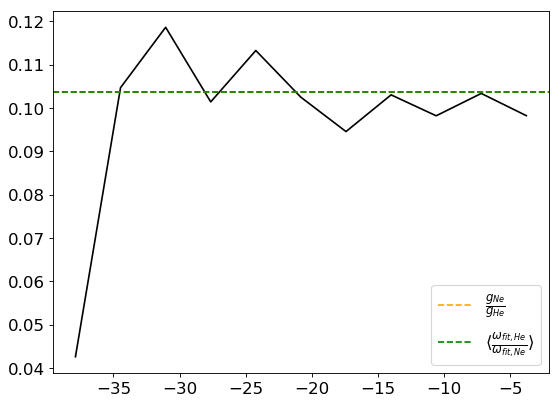

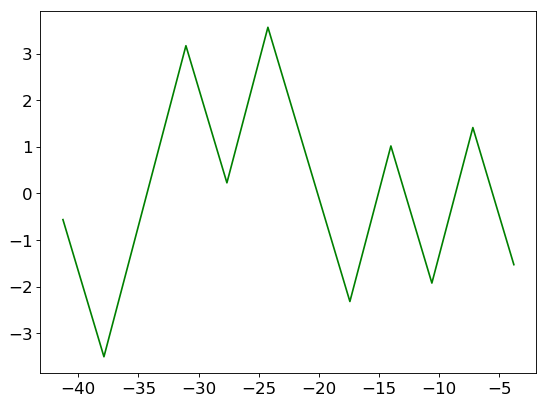

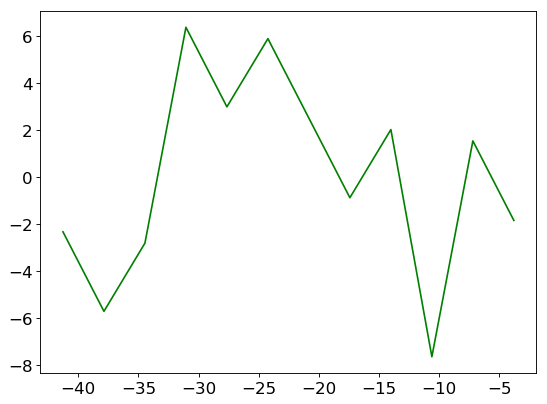

In [258]:
n=2*np.pi
f=(gHe*2*np.pi*dataPar_x[-1,-1] + paraOut_arr[-1,2])/(gNe*2*np.pi*dataPar_x[-1,-1] + paraOut_arr[-1,5])
f = np.mean(paraOut_arr[i,1])/np.mean(paraOut_arr[i,4])
phi1_arr0 = paraOut_arr[:,2].copy()
phi2_arr0 = paraOut_arr[:,5].copy()
phi1_arr = phi1_arr0.copy()
phi2_arr = phi2_arr0.copy()
N1Cum = 0
N2Cum = 0
for i in range(1, len(phi1_arr)):
    N1 = np.floor(np.mean(paraOut_arr[i,1])*(dataPar_x[1,0]-dataPar_x[0,0])/n)
    N2 = np.floor(np.mean(paraOut_arr[i,4])*(dataPar_x[1,0]-dataPar_x[0,0])/n)
    minVal = 999
    phi1M = 0
    phi2M = 0
    N1M = 0
    N2M = 0
    for N1A in range(-1,2):
        for N2A in range(-1,2):
            phi1T = phi1_arr[i] + n*(N1Cum+N1+N1A)
            phi2T = phi2_arr[i] + n*(N2Cum+N2+N2A)
            if np.abs( (phi1T-np.mean(phi1_arr[0]))/(phi2T-np.mean(phi2_arr[0])) - f ) < minVal:
                phi1M = phi1T
                phi2M = phi2T
                N1M = N1A
                N2M = N2A
                minVal = np.abs( (phi1T-np.mean(phi1_arr[0]))/(phi2T-np.mean(phi2_arr[0])) -  f )
    phi1_arr[i] = phi1M
    phi2_arr[i] = phi2M
    N1Cum += N1+N1M
    N2Cum += N2+N2M

fratio_steps = (phi1_arr-np.mean(phi1_arr[0]))/(phi2_arr-np.mean(phi2_arr[0]))
plt.figure()
plt.plot( np.mean(dataPar_x, axis=1), fratio_steps, c="black")
plt.axhline(gNe/gHe, ls="--", c='orange', label="$\\frac{g_{Ne}}{g_{He}}$")
plt.axhline(f, ls="--", c="green", label="$\\langle \\frac{\\omega_{fit,He}}{\\omega_{fit,Ne}} \\rangle$")
plt.legend()

phi1_fit = linregress( np.mean(dataPar_x, axis=1), phi1_arr )
phi2_fit = linregress( np.mean(dataPar_x, axis=1), phi2_arr )
print(phi1_fit[0], phi2_fit[0])
plt.figure()
plt.plot( np.mean(dataPar_x, axis=1), (phi1_arr - (phi1_fit[1] + np.mean(dataPar_x, axis=1)*phi1_fit[0])), c="green")
plt.figure()
plt.plot( np.mean(dataPar_x, axis=1), (phi2_arr - (phi2_fit[1] + np.mean(dataPar_x, axis=1)*phi2_fit[0])), c="green")

In [379]:
n=2*np.pi
phi1_arr = paraOut_arr[:,2].copy()
phi2_arr = paraOut_arr[:,5].copy()
N1 = np.round(15.088*gNe/gHe*(dataPar_x[1,0]-dataPar_x[0,0])/n)
N2 = np.round(15.088*(dataPar_x[1,0]-dataPar_x[0,0])/n)
test_arr = []
vald = 0
valu = 3
for i1 in np.arange(vald,valu+1):
    for i2 in np.arange(vald,valu+1):
        for i3 in np.arange(vald,valu+1):
            test_arr.append(np.array([0, i1, i1+i2, i1+i2+i3 ]))
            
l = 4
resmin1 = np.inf
resmin2 = np.inf
for it, test in enumerate(test_arr):
    phi1_arrT = n*(test+np.arange(0,l)*N1) + phi1_arr[:l].copy()
    phi1_fit3 = linregress( np.mean(dataPar_x, axis=1)[:l], phi1_arrT )
    if phi1_fit3[0] > 0 and np.sum((phi1_arrT - (phi1_fit3[1] + np.mean(dataPar_x, axis=1)[:l]*phi1_fit3[0]))**2) < resmin1:
        add1 = test+np.arange(0,l)*N1
        resmin1 = np.sum((phi1_arrT - (phi1_fit3[1] + np.mean(dataPar_x, axis=1)[:l]*phi1_fit3[0]))**2)  

    phi2_arrT = n*(test+np.arange(0,l)*N2) + phi2_arr[:l].copy()
    phi2_fit3 = linregress( np.mean(dataPar_x, axis=1)[:l], phi2_arrT )
    if phi2_fit3[0] > 0 and np.sum((phi2_arrT - (phi2_fit3[1] + np.mean(dataPar_x, axis=1)[:l]*phi2_fit3[0]))**2) < resmin2:
        add2 = test+np.arange(0,l)*N2
        resmin2 = np.sum((phi2_arrT - (phi2_fit3[1] + np.mean(dataPar_x, axis=1)[:l]*phi2_fit3[0]))**2) 

phi1_arr[:l] = n*add1 + phi1_arr[:l]
phi2_arr[:l] = n*add2 + phi2_arr[:l]
NCum1 = add1[-1]
NCum2 = add2[-1]
add1 = 0
add2 = 0
for i in range(len(phi1_arr)-l):
    ind = l+i
    resmin1 = np.inf
    resmin2 = np.inf
    for i0 in np.arange(vald,valu+1):
        phi1_arrT = phi1_arr[:ind+1].copy()
        phi1_arrT[-1] = phi1_arrT[-1] + n*(NCum1+N1+i0)
        phi1_fit = linregress( np.mean(dataPar_x, axis=1)[:ind+1], phi1_arrT )
        if phi1_fit[0] > 0 and np.sum((phi1_arrT - (phi1_fit[1] + np.mean(dataPar_x, axis=1)[:ind+1]*phi1_fit[0]))**2) < resmin1:
            add1 = N1+i0
            resmin1 = np.sum((phi1_arrT - (phi1_fit[1] + np.mean(dataPar_x, axis=1)[:ind+1]*phi1_fit[0]))**2)
            
        phi2_arrT = phi2_arr[:ind+1].copy()
        phi2_arrT[-1] = phi2_arrT[-1] + n*(NCum2+N2+i0)
        phi2_fit = linregress( np.mean(dataPar_x, axis=1)[:ind+1], phi2_arrT )
        if phi2_arrT[-1] > phi2_arrT[-2] and np.sum((phi2_arrT - (phi2_fit[1] + np.mean(dataPar_x, axis=1)[:ind+1]*phi2_fit[0]))**2) < resmin2:
            add2 = N2+i0
            resmin2 = np.sum((phi2_arrT - (phi2_fit[1] + np.mean(dataPar_x, axis=1)[:ind+1]*phi2_fit[0]))**2)
    print(add1-N1, add2-N2)
    phi1_arr[ind] = phi1_arr[ind] + n*(NCum1+add1)
    NCum1 = NCum1 + add1
    phi2_arr[ind] = phi2_arr[ind] + n*(NCum2+add2)
    NCum2 = NCum2 + add2

1.0 1.0
0.0 2.0
0.0 1.0
1.0 1.0
0.0 1.0
0.0 2.0
0.0 1.0
1.0 1.0


2.408916765192758 16.976538105015987
1.5564089044718499 15.018618701743526


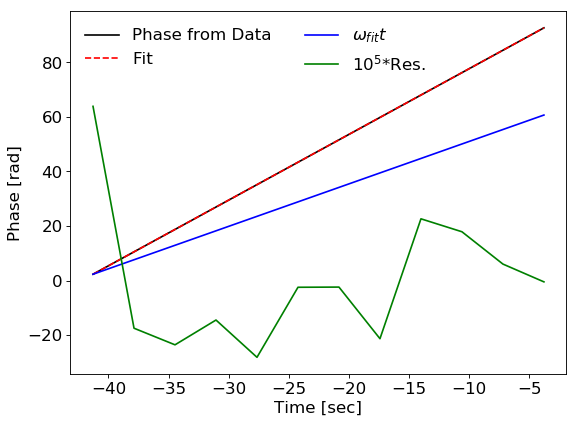

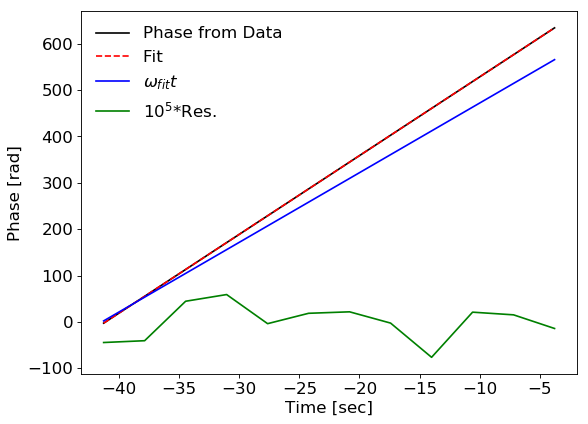

In [406]:
phi1_fit = linregress( np.mean(dataPar_x, axis=1), phi1_arr )
plt.figure()
plt.plot( np.mean(dataPar_x, axis=1), phi1_arr, c="black", label="Phase from Data")
plt.plot( np.mean(dataPar_x, axis=1), phi1_fit[1] + np.mean(dataPar_x, axis=1)*phi1_fit[0], c="red", ls="--", label="Fit")
plt.plot( np.mean(dataPar_x, axis=1), phi1_arr[0]+(np.mean(dataPar_x, axis=1)-np.mean(dataPar_x, axis=1)[0])*np.mean(paraOut_arr[:,1]), c="blue", label="$\omega_{fit}t$")
plt.plot( np.mean(dataPar_x, axis=1), 100000*(phi1_arr - (phi1_fit[1] + np.mean(dataPar_x, axis=1)*phi1_fit[0])), c="green", label="$10^5$*Res.")
plt.legend(frameon=False, ncol=2 )
plt.xlabel("Time [sec]")
plt.ylabel("Phase [rad]")
phi2_fit = linregress( np.mean(dataPar_x, axis=1), phi2_arr )
plt.figure()
plt.plot( np.mean(dataPar_x, axis=1), phi2_arr, c="black", label="Phase from Data")
plt.plot( np.mean(dataPar_x, axis=1), phi2_fit[1] + np.mean(dataPar_x, axis=1)*phi2_fit[0], c="red", ls="--", label="Fit")
plt.plot( np.mean(dataPar_x, axis=1), phi1_arr[0]+(np.mean(dataPar_x, axis=1)-np.mean(dataPar_x, axis=1)[0])*np.mean(paraOut_arr[:,4]), c="blue", label="$\omega_{fit}t$")
plt.plot( np.mean(dataPar_x, axis=1), 100000*(phi2_arr - (phi2_fit[1] + np.mean(dataPar_x, axis=1)*phi2_fit[0])), c="green", label="$10^5$*Res.")
plt.legend(frameon=False)
plt.xlabel("Time [sec]")
plt.ylabel("Phase [rad]")
print(phi1_fit[0],phi2_fit[0])
print(np.mean(paraOut_arr[:,1]), np.mean(paraOut_arr[:,4]))